## Problem Statement: Predict the Product based on the complaints made by the customer.

### Installing the necessary Libraries: 

In [ ]:
# !pip install -U -q PyDrive
# !pip install nltk


### Importing the necessary Libraries:

In [2]:
#Basic libraries
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials




#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
ps = PorterStemmer()




# Machine Learning libraries
import sklearn 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
cv = StratifiedKFold(n_splits=15, random_state=1, shuffle=True)
nb = MultinomialNB()
LR = LogisticRegression(multi_class="multinomial")
RF = RandomForestClassifier()
KNN = KNeighborsClassifier()
GB = GradientBoostingClassifier()




 

#Classification Metrics libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


nltk.download('stopwords')


## Deployment libraries
import pickle


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Authenticating the google drive folder:

In [ ]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
# # https://drive.google.com/file/d/1A9tUpNpbM4DPsnWZyI1bvgKoDkyeK7xS/view?usp=sharing
# fileDownloaded = drive.CreateFile({'id':'1A9tUpNpbM4DPsnWZyI1bvgKoDkyeK7xS'})
# fileDownloaded.GetContentFile('complaints.csv')


### Read the dataset:

In [3]:
df=pd.read_csv('https://media.githubusercontent.com/media/Shivadhulipala/customer_complaints/master/complaints.csv')

In [4]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2019-08-24,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Privacy issues,on or about XX/XX/2019 Capital one failure to ...,NaN,CAPITAL ONE FINANCIAL CORPORATION,CO,802XX,NaN,Consent provided,Web,2019-08-24,Closed with explanation,Yes,NaN,3352752
4,2021-08-31,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,I am filing a complaint against CONVERGENT OUT...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",TX,765XX,Servicemember,Consent provided,Web,2021-08-31,Closed with explanation,Yes,NaN,4677754


> **Insights:**

*   From the dataset we understand that the dataset is a banking complaints dataset of United states region where in the cases of disputes between the bank and the customer, the complaints have been filed.

* we understand that the customers who have not provided thier consent through the web is a Nan value which is being displayed. Hence we cannot impute any missing values in this case.




In [ ]:
df.shape

(2318996, 18)

In [ ]:
df.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235164
Issue                                 0
Sub-issue                        634405
Consumer complaint narrative    1513382
Company public response         1364115
Company                               0
State                             40267
ZIP code                         223423
Tags                            2035063
Consumer consent provided?       725101
Submitted via                         0
Date sent to company                  0
Company response to consumer          1
Timely response?                      0
Consumer disputed?              1550537
Complaint ID                          0
dtype: int64

In [ ]:
# df['Consumer complaint narrative'].replace(np.nan,'No Data',inplace=True)
df = df[df['Consumer complaint narrative'].notna()]



> Instead of removing all the null values, lets discard the null values in this case they cannot be imputed as it is a sentenced text. We're just discarding the null values and taking the values wich are not null for "Consumer complaint narrative".






In [ ]:
df.isnull().sum()

Date received                        0
Product                              0
Sub-product                      52172
Issue                                0
Sub-issue                       168189
Consumer complaint narrative         0
Company public response         414045
Company                              0
State                             3545
ZIP code                        176759
Tags                            676578
Consumer consent provided?           0
Submitted via                        0
Date sent to company                 0
Company response to consumer         1
Timely response?                     0
Consumer disputed?              641552
Complaint ID                         0
dtype: int64

In [ ]:
df['Consumer complaint narrative'].shape

(805614,)

### Dividing the dataset into Training and test set by random sampling:

In [ ]:
train_data = df.sample(frac=.75)
train_data.reset_index(inplace=True)
train_data = train_data[['Consumer complaint narrative','Product']]
test_data = df.sample(frac=.25)

In [ ]:
train_data

,Consumer complaint narrative,Product
0,My complaint is against Bank of America. \n\nB...,Checking or savings account
1,Tax liens have been released.,Credit reporting
2,This has been an ongoing issue since 2018. My ...,"Credit reporting, credit repair services, or o..."
3,Received call on cell phone about a non-existe...,Debt collection
4,My credit card balance is {$0.00} on my XXXXXX...,"Credit reporting, credit repair services, or o..."
...,...,...
604205,Was XXXX contacted by a strange number XXXX XX...,Debt collection
604206,I requested the method of there investigation ...,"Credit reporting, credit repair services, or o..."
604207,XXXX HAS INDUCED ME TO APPLY TO WELLS FARGO UN...,"Credit reporting, credit repair services, or o..."
604208,I have multiple inquiries on my credit that I ...,"Credit reporting, credit repair services, or o..."


### Lets try to understand the complaints of the customers:

In [ ]:
pd.set_option('display.max_colwidth',-1)

In [ ]:
train_data.head()

,Consumer complaint narrative,Product
0,"My complaint is against Bank of America. \n\nBank of America was making monthly automatic payments to XXXX XXXX XXXX from my BOA checking account. In late XXXX, the XXXX XXXX XXXX was paid in full and the account closed. Inadvertently, Bank of America made one extra payment to XXXX XXXX for {$2600.00} on XX/XX/2020, after the XXXX XXXX XXXX account was closed. I contacted both XXXX XXXXXXXX and Bank of America as soon as I discovered the debit from my Bank of America account. Both institutions assured me that the overpayment would by credited back to my Bank of America account. \n\nAfter several weeks of not seeing the refund post, I initiated a case with Bank of America, first trying their telephone support and later through their messaging center. \n\nXXXX XXXXXXXX sent a letter to Bank of America on XX/XX/XXXX, stating, "" Enclosed please find check number XXXX dated XX/XX/2020 in the amount of {$2600.00} ... '' I am attaching the complete letter below. \n\nOn XX/XX/2020, I received a message from Bank of America stating, "" This credit will post to your account within 5 to 7 business days ... '' I am attaching the complete message below. \n\nAfter seven business days the credit still had not posted. \n\nOn XX/XX/2020, I received another message from Bank of America stating, "" This credit will post to your account within 5 to 7 business days ... '' I am attaching the complete message below. \n\nI am attaching all written correspondence I have had with XXXX XXXXXXXX and Bank of America. \n\nOn XX/XX/2020, I went to the Bank of America XXXX office at XXXX XXXX XXXX XXXX XXXX XXXX XXXX, MD XXXX. I spoke at great length with the branch manager, XXXX XXXX. He assured me that the matter would be rectified by XX/XX/2020. Mr. XXXX is not taking or returning my telephone calls at this time. \n\nIn addition, today I discovered that every message concerning this case in my Bank of America account online web page has been mysteriously deleted. Fortunately, I made copies before these disappeared.",Checking or savings account
1,Tax liens have been released.,Credit reporting
2,"This has been an ongoing issue since 2018. My next step is to file a lawsuit against Experian. Experian is reporting a balance of {$12000.00} with a company called XXXX XXXX XXXX. I received the official statement from the original creditor which is listing a balance on {$3500.00}. These two companies obviously can not have two completely different balances. I have sent multiple disputes that have came back inaccurately as verified.This is a violation of my consumer rights. you are alleging the negative claims still yet deficit of proof of truth, correctness, completeness, timeliness, and or else wise adequate COMPLIANCE to all laws and the Metro 2 data field formatted reporting standards, therefore lawfully you MUST ERADICATE any and all adverse remarks :","Credit reporting, credit repair services, or other personal consumer reports"
3,Received call on cell phone about a non-existent debt. Phone is registered on federal Do Not Call list. Message sounded like a scam. There was NO phone message other than a claimed debt which was NOT described. The number appears to be identified on XXXX XXXX XXXX AND XXXX as a SCAM. TSC is identified as the entity originating the call. NO documents have been received or referred to.,Debt collection
4,My credit card balance is {$0.00} on my XXXXXXXX XXXX XXXX and all three bureaus keep showing it as {$10.00} over the limit. Then they won't let me dispute the balance.,"Credit reporting, credit repair services, or other personal consumer reports"


In [ ]:
# Since we have understood the input data, now it is time to understand the distribution of the output column.
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    314292
Debt collection                                                                 156805
Mortgage                                                                        84262 
Credit card or prepaid card                                                     60466 
Checking or savings account                                                     37178 
Credit reporting                                                                31588 
Student loan                                                                    29058 
Credit card                                                                     18838 
Money transfer, virtual currency, or money service                              18468 
Vehicle loan or lease                                                           14943 
Bank account or service                                                         14885 
Payday loan, title loan, or personal loan  

> We're Making changes to the feature engineering column as we could find that the categories are misclassified. For example, there are 214370 complaints regarding the credit reporting,credit repair services, or other personal consumer reports and again there are 35182 for only credit reporting. So, we're grouping all the complaints into one.

In [ ]:
train_data['Product'] = train_data['Product'].replace('Credit reporting','Credit reporting, credit repair services, or other personal consumer reports')

In [ ]:
train_data['Product'] = train_data['Product'].replace('Prepaid card','Credit card or prepaid card')

In [ ]:
train_data['Product'] = train_data['Product'].replace('Virtual currency','Money transfer, virtual currency, or money service')

In [ ]:
train_data['Product'] = train_data['Product'].replace('Money transfers','Money transfer, virtual currency, or money service')

In [ ]:
train_data['Product'] = train_data['Product'].replace('Credit card','Credit card or prepaid card')

In [ ]:
train_data['Product'] = train_data['Product'].replace('Payday loan','Payday loan, title loan, or personal loan')

In [ ]:
train_data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    259409
Debt collection                                                                 117885
Mortgage                                                                        63262 
Credit card or prepaid card                                                     60357 
Checking or savings account                                                     27906 
Student loan                                                                    21680 
Money transfer, virtual currency, or money service                              15046 
Vehicle loan or lease                                                           11185 
Bank account or service                                                         11129 
Payday loan, title loan, or personal loan                                       9052  
Consumer Loan                                                                   7076  
Other financial service                    

> From the data distribution we understand that the major complaints from the customers are Credit card complaints however, if we see personal loans there are very less complaints which the dataset indicates that the dataset is imbalanced. However, we can feed this current data to the model as it is and however, the under represented classes will not be modelled correctly. Inorder to overcome this, we assign weights to these classes.

In [ ]:
print(train_data['Consumer complaint narrative'][1:6]) 

1    Tax liens have been released.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2    This has been an ongoing issue since 2018. My next step is to file a lawsuit against Experian. Experian is reporting a balance of {$12000.00} with a company called XXXX  XXXX XXXX. I received the official statement from th

In [ ]:
print(re.sub(r'@+','',train_data['Consumer complaint narrative'][5]))

My payroll check was direct deposit to my rushcard and it 's not there talking about they doing a upgrade system I have bill that due and kids that I need to feed


In [ ]:
print(re.sub('http?://[A-Za-z0-9./]+','',train_data['Consumer complaint narrative'][10]))

Goldman Sachs issued me an apple credit Card through an XXXX account I had separate on my XXXX. XXXX was stolen and i called right away to report it. Unable to retrieve it I endured unauthorized charges to which the company couldnt explain yet Im being billed continuously monthly for charges that are not listed on my bank statement or that they can explain. They told me they cant access the transactions and only I could do it through an XXXX  account I cant get into. This being said, they offered to mail me the itemized statement. I received an itemized statement with no charges shown but a total amount of {$430.00} to Be paid. They wont dispute or close my account


In [ ]:
print(re.sub("[^a-zA-Z0-9]", " ",train_data['Consumer complaint narrative'][22]))
print(re.sub("[^a-zA-Z0-9]", " ",train_data['Consumer complaint narrative'][10]))


Recently I received a collection letter from a law firm known as XXXX XXXX XXXX  XXXX  claiming that they were trying to collect on a debt for a debt buyer known as XXXX XXXX XXXX  XXXX  There are issues that need to be rectified as there is no consistency pertaining to debt ownership  The following is the criteria that must be established in order to validate a collectible debt against me   1   At no time was I ever notified that an old debt was purchased by XXXX XXXX XXXX XXXX XXXX   2   The debt is so old that it no longer is posted on any of my credit reports  which means that at the very least the debt is over 7 years since it was last posted on a bureau update   3   Any debt purchase in the Commonwealth of Massachusetts must show true copy ownership  as in this case XXXX XXXX XXXX  did no such transfer  nor was I ever given any such proof   4   The debt information was acquired through a debt pooling information program electronically  and thus this collection is a fraudulent tra

### Text Pre-processing:

In [ ]:
tokenizer = WordPunctTokenizer()
def text_cleaner(text):
    text=re.sub(r'@+','',text)
    text=re.sub(r'X+','',text)
    text=re.sub('http?://[A-Za-z0-9./]+','',text)
    text=re.sub("[^a-zA-Z]", " ",text)
    lower_case = text.lower()
    words = tokenizer.tokenize(lower_case)
    return (" ".join(words)).strip()



> We're using Regular expressions to remove all the uncessary content in the text at once to make it clean inorder to make vectors that would be fed to the model for evaluation.



In [ ]:
clean_text = list(map(lambda x:text_cleaner(x),train_data['Consumer complaint narrative']))

In [ ]:
train_data['clean_text'] = clean_text

In [ ]:
train_data.head()

,Consumer complaint narrative,Product,clean_text
0,"My complaint is against Bank of America. \n\nBank of America was making monthly automatic payments to XXXX XXXX XXXX from my BOA checking account. In late XXXX, the XXXX XXXX XXXX was paid in full and the account closed. Inadvertently, Bank of America made one extra payment to XXXX XXXX for {$2600.00} on XX/XX/2020, after the XXXX XXXX XXXX account was closed. I contacted both XXXX XXXXXXXX and Bank of America as soon as I discovered the debit from my Bank of America account. Both institutions assured me that the overpayment would by credited back to my Bank of America account. \n\nAfter several weeks of not seeing the refund post, I initiated a case with Bank of America, first trying their telephone support and later through their messaging center. \n\nXXXX XXXXXXXX sent a letter to Bank of America on XX/XX/XXXX, stating, "" Enclosed please find check number XXXX dated XX/XX/2020 in the amount of {$2600.00} ... '' I am attaching the complete letter below. \n\nOn XX/XX/2020, I received a message from Bank of America stating, "" This credit will post to your account within 5 to 7 business days ... '' I am attaching the complete message below. \n\nAfter seven business days the credit still had not posted. \n\nOn XX/XX/2020, I received another message from Bank of America stating, "" This credit will post to your account within 5 to 7 business days ... '' I am attaching the complete message below. \n\nI am attaching all written correspondence I have had with XXXX XXXXXXXX and Bank of America. \n\nOn XX/XX/2020, I went to the Bank of America XXXX office at XXXX XXXX XXXX XXXX XXXX XXXX XXXX, MD XXXX. I spoke at great length with the branch manager, XXXX XXXX. He assured me that the matter would be rectified by XX/XX/2020. Mr. XXXX is not taking or returning my telephone calls at this time. \n\nIn addition, today I discovered that every message concerning this case in my Bank of America account online web page has been mysteriously deleted. Fortunately, I made copies before these disappeared.",Checking or savings account,my complaint is against bank of america bank of america was making monthly automatic payments to from my boa checking account in late the was paid in full and the account closed inadvertently bank of america made one extra payment to for on after the account was closed i contacted both and bank of america as soon as i discovered the debit from my bank of america account both institutions assured me that the overpayment would by credited back to my bank of america account after several weeks of not seeing the refund post i initiated a case with bank of america first trying their telephone support and later through their messaging center sent a letter to bank of america on stating enclosed please find check number dated in the amount of i am attaching the complete letter below on i received a message from bank of america stating this credit will post to your account within to business days i am attaching the complete message below after seven business days the credit still had not posted on i received another message from bank of america stating this credit will post to your account within to business days i am attaching the complete message below i am attaching all written correspondence i have had with and bank of america on i went to the bank of america office at md i spoke at great length with the branch manager he assured me that the matter would be rectified by mr is not taking or returning my telephone calls at this time in addition today i discovered that every message concerning this case in my bank of america account online web page has been mysteriously deleted fortunately i made copies before these disappeared
1,Tax liens have been released.,"Credit reporting, credit repair services, or other personal consumer reports",tax liens have been released
2,"This has been an ongoing issue since 2018. My next step is to file a lawsuit against Experian. Experian i

In [ ]:
for group_name,subset in train_data.groupby('Product'):
  Data = subset['clean_text']
  words=[]
  for each in Data:
    words.extend(each.split(" "))
  print(group_name)
  print(Counter(words).most_common(15))

Bank account or service
[('the', 115584), ('i', 102099), ('to', 87798), ('and', 69942), ('my', 54377), ('a', 52698), ('that', 42316), ('of', 40964), ('was', 39259), ('account', 36520), ('in', 30179), ('they', 27742), ('bank', 27266), ('on', 27222), ('me', 26302)]
Checking or savings account
[('the', 307093), ('i', 270739), ('to', 243306), ('and', 193885), ('my', 156453), ('a', 135591), ('that', 111455), ('was', 107788), ('of', 107110), ('account', 102984), ('on', 81305), ('in', 78188), ('they', 75019), ('me', 74108), ('for', 67267)]
Consumer Loan
[('the', 65904), ('i', 63283), ('to', 50342), ('and', 40729), ('a', 31768), ('my', 29551), ('was', 24287), ('that', 23273), ('of', 21817), ('they', 19206), ('in', 17322), ('on', 16785), ('for', 14972), ('me', 14904), ('have', 14395)]
Credit card or prepaid card
[('the', 597037), ('i', 570948), ('to', 457601), ('and', 369129), ('my', 281419), ('a', 280321), ('that', 219360), ('was', 208871), ('of', 202562), ('on', 176977), ('in', 150904), ('the



> We understand that the most of the repeated words are prepositions and the words that present in the stop words. Hence, we remove all the text containing stop_words and try to get an insight on the text that containts no stop_words.



In [ ]:
stop_words = stopwords.words('english')
train_data['Stop_words_removed'] = train_data['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [ ]:
train_data.head()

,Consumer complaint narrative,Product,clean_text,Stop_words_removed
0,"My complaint is against Bank of America. \n\nBank of America was making monthly automatic payments to XXXX XXXX XXXX from my BOA checking account. In late XXXX, the XXXX XXXX XXXX was paid in full and the account closed. Inadvertently, Bank of America made one extra payment to XXXX XXXX for {$2600.00} on XX/XX/2020, after the XXXX XXXX XXXX account was closed. I contacted both XXXX XXXXXXXX and Bank of America as soon as I discovered the debit from my Bank of America account. Both institutions assured me that the overpayment would by credited back to my Bank of America account. \n\nAfter several weeks of not seeing the refund post, I initiated a case with Bank of America, first trying their telephone support and later through their messaging center. \n\nXXXX XXXXXXXX sent a letter to Bank of America on XX/XX/XXXX, stating, "" Enclosed please find check number XXXX dated XX/XX/2020 in the amount of {$2600.00} ... '' I am attaching the complete letter below. \n\nOn XX/XX/2020, I received a message from Bank of America stating, "" This credit will post to your account within 5 to 7 business days ... '' I am attaching the complete message below. \n\nAfter seven business days the credit still had not posted. \n\nOn XX/XX/2020, I received another message from Bank of America stating, "" This credit will post to your account within 5 to 7 business days ... '' I am attaching the complete message below. \n\nI am attaching all written correspondence I have had with XXXX XXXXXXXX and Bank of America. \n\nOn XX/XX/2020, I went to the Bank of America XXXX office at XXXX XXXX XXXX XXXX XXXX XXXX XXXX, MD XXXX. I spoke at great length with the branch manager, XXXX XXXX. He assured me that the matter would be rectified by XX/XX/2020. Mr. XXXX is not taking or returning my telephone calls at this time. \n\nIn addition, today I discovered that every message concerning this case in my Bank of America account online web page has been mysteriously deleted. Fortunately, I made copies before these disappeared.",Checking or savings account,my complaint is against bank of america bank of america was making monthly automatic payments to from my boa checking account in late the was paid in full and the account closed inadvertently bank of america made one extra payment to for on after the account was closed i contacted both and bank of america as soon as i discovered the debit from my bank of america account both institutions assured me that the overpayment would by credited back to my bank of america account after several weeks of not seeing the refund post i initiated a case with bank of america first trying their telephone support and later through their messaging center sent a letter to bank of america on stating enclosed please find check number dated in the amount of i am attaching the complete letter below on i received a message from bank of america stating this credit will post to your account within to business days i am attaching the complete message below after seven business days the credit still had not posted on i received another message from bank of america stating this credit will post to your account within to business days i am attaching the complete message below i am attaching all written correspondence i have had with and bank of america on i went to the bank of america office at md i spoke at great length with the branch manager he assured me that the matter would be rectified by mr is not taking or returning my telephone calls at this time in addition today i discovered that every message concerning this case in my bank of america account online web page has been mysteriously deleted fortunately i made copies before these disappeared,complaint bank america bank america making monthly automatic payments boa checking account late paid full account closed inadvertently bank america made one extra payment account closed contacted bank america soon discovered debi

In [ ]:
for group_name,subset in train_data.groupby('Product'):
  Data = subset['Stop_words_removed']
  words=[]
  for each in Data:
    words.extend(each.split(" "))
  print(group_name)
  print(Counter(words).most_common(15))

Bank account or service
[('account', 36520), ('bank', 27266), ('would', 10871), ('money', 9727), ('check', 9129), ('told', 8961), ('card', 7971), ('n', 7655), ('credit', 7091), ('checking', 6207), ('called', 6017), ('fees', 6016), ('funds', 5703), ('time', 5701), ('back', 5698)]
Checking or savings account
[('account', 102984), ('bank', 65524), ('money', 28089), ('would', 26359), ('told', 24624), ('check', 23399), ('funds', 19301), ('called', 19262), ('card', 18209), ('back', 17697), ('checking', 17314), ('received', 15718), ('said', 15432), ('time', 15003), ('one', 14943)]
Consumer Loan
[('loan', 10237), ('payment', 9639), ('credit', 8945), ('car', 7034), ('would', 6680), ('account', 6508), ('told', 5295), ('payments', 5275), ('vehicle', 4682), ('n', 4580), ('pay', 4363), ('paid', 3887), ('company', 3820), ('time', 3794), ('called', 3756)]
Credit card or prepaid card
[('card', 140528), ('credit', 135170), ('account', 106390), ('would', 54756), ('bank', 51051), ('payment', 50977), ('to



> Now, we have the text that contains no stop words and the most common and most repeated words are displayed above which are top_15_common words.



### **Visualisation:**

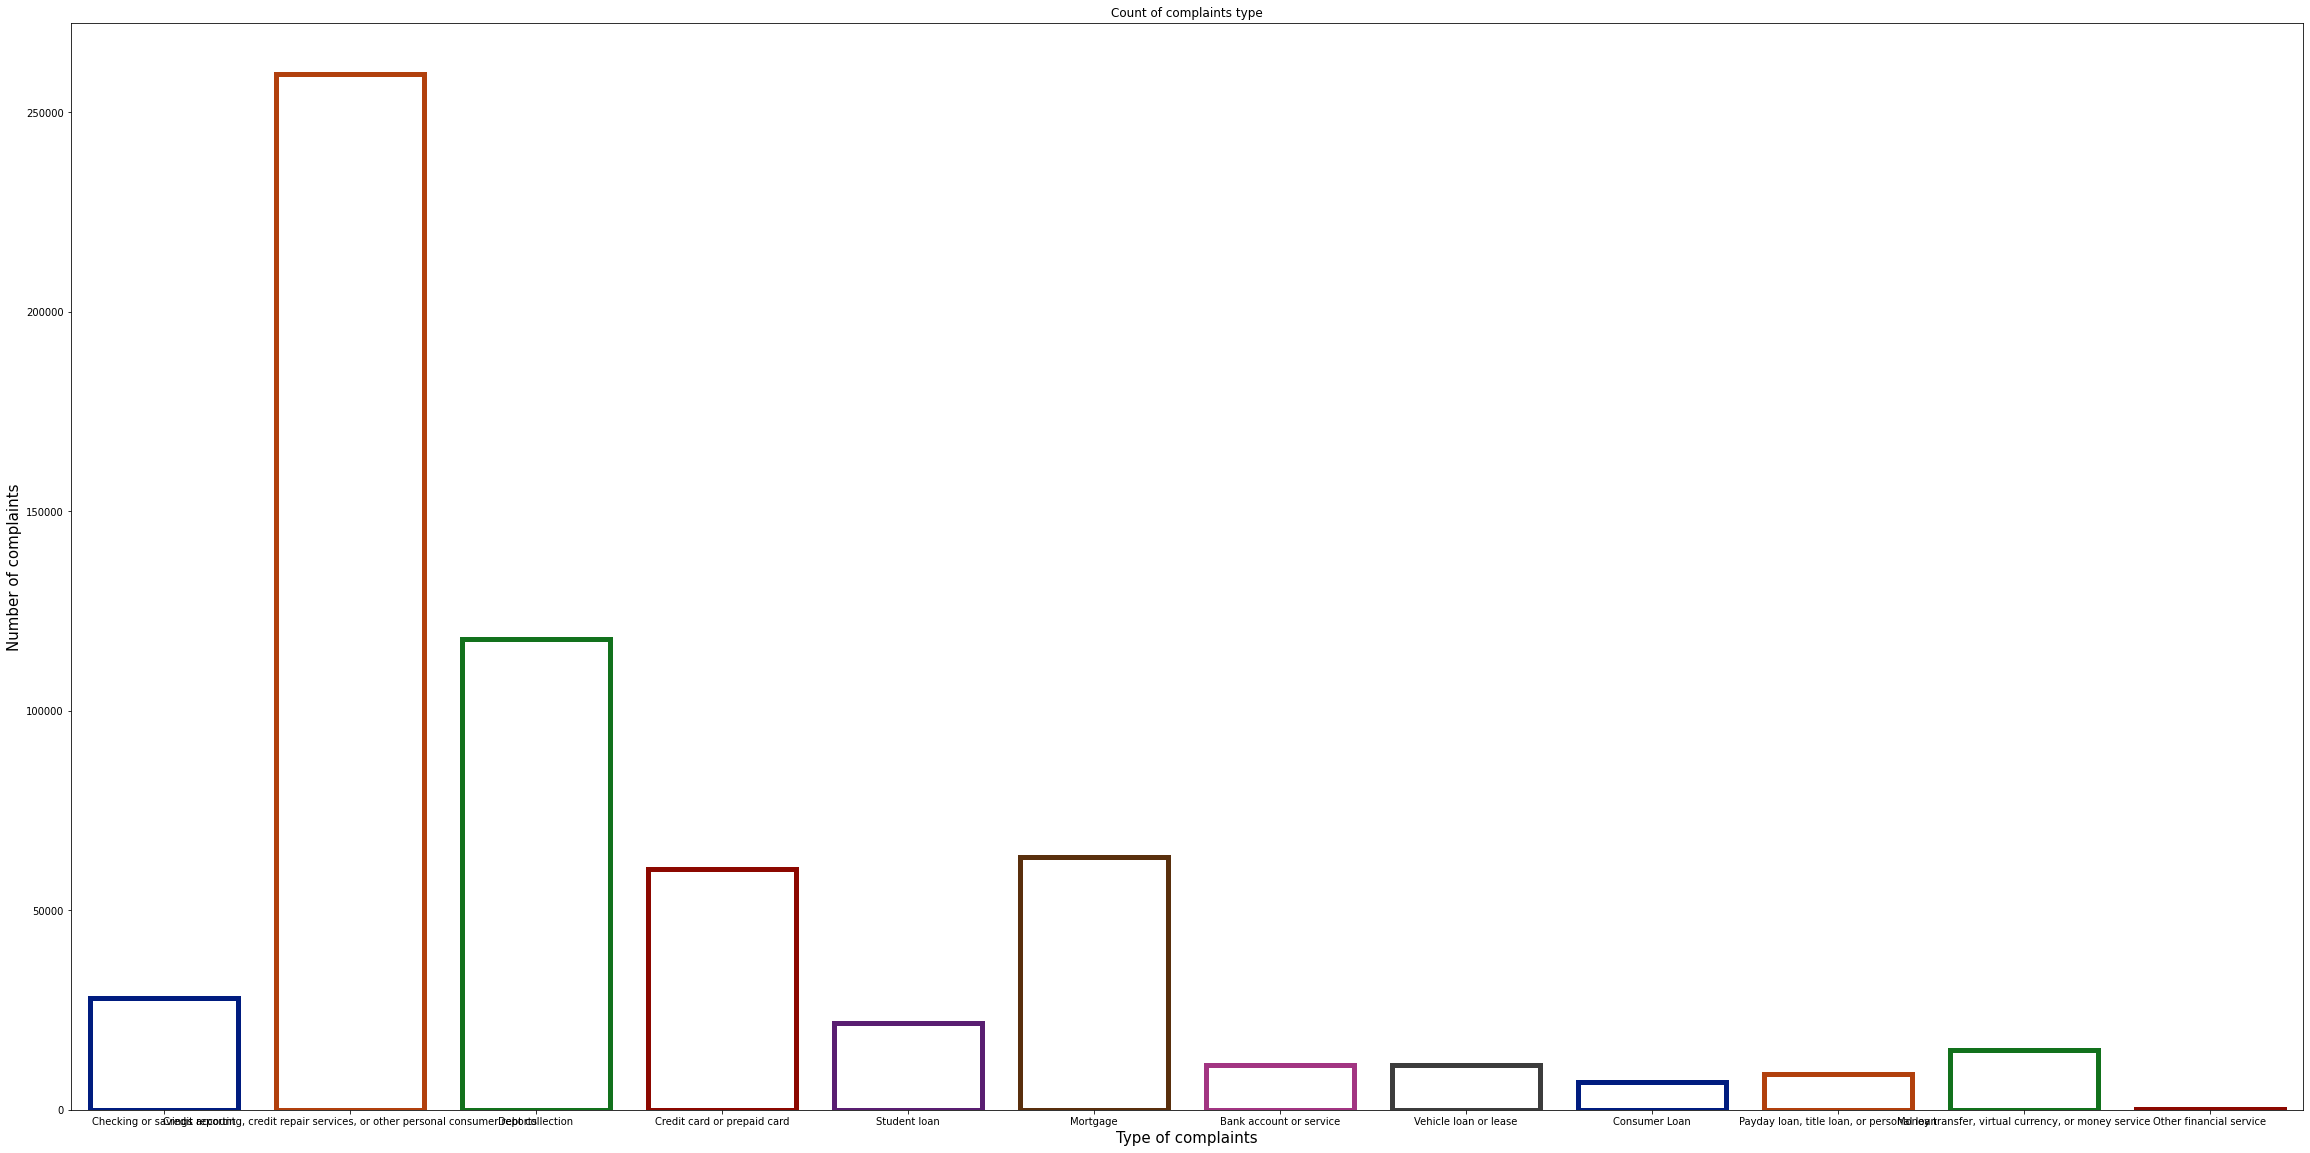

In [ ]:
# Plotting the frequency plot
plt.figure(figsize=(40,20))
ax = sns.countplot(x="Product", data=train_data,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 8))

# Setting labels and font size
ax.set(xlabel='Type of complaints', ylabel='Number of complaints',title='Count of complaints type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

## Extracting new features from the dataset:

Lets extract more features from the data such as<br>

Polarity: The measure which signifies the sentiment analysis of the data<br>
Review length: Length of the complaints(number of letters and spaces)<br>
Word Count: Number of words in the complaints<br>

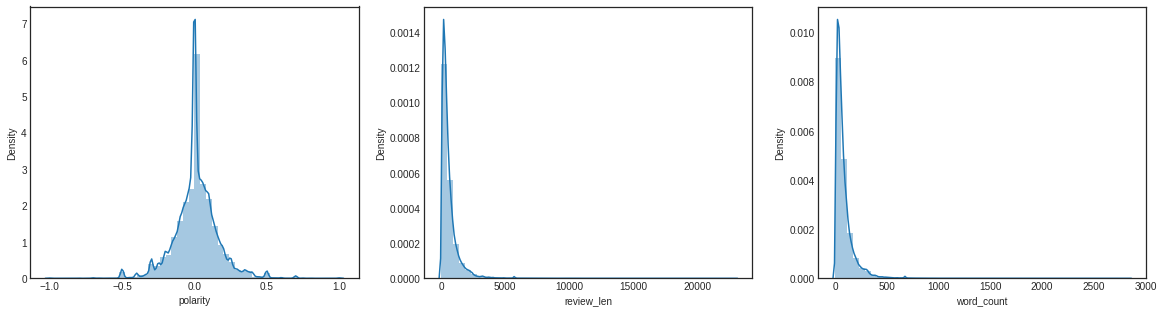

In [ ]:
#Extracting the features from the complaints
train_data['polarity'] = train_data['Stop_words_removed'].map(lambda text: TextBlob(text).sentiment.polarity)
train_data['review_len'] = train_data['Stop_words_removed'].astype(str).apply(len)
train_data['word_count'] = train_data['Stop_words_removed'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(train_data['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(train_data['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(train_data['word_count'])
fig = plt.gcf()

##### Insights:
- Most of the polarity are neutral. There are some negative and positive sentimentts.
- The word count is between 0-3500.
- The length of the complaints are between 0-5000 and few near 25000 words which could be an article.

## N-gram analysis:
### Top 20 words in complaints:
Let's have a look at the top 20 words from the complaints which could give us a brief idea on what type of complaints that are popular in our dataset

In [ ]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vector = CountVectorizer().fit(corpus)
    bag_of_words = vector.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(train_data['Stop_words_removed'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['complaints' , 'count'])

#Group by words and plot the sum
df1.groupby('complaints').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in complaints')

credit 1027220
account 824582
report 474733
information 437623
payment 357109
would 352763
loan 320081
debt 312900
bank 287160
received 276855
reporting 274894
company 268089
told 266975
card 245470
time 237942
never 229495
called 224820
sent 224077
accounts 213390
letter 206799


##### Insights:
- All the top 20 words are about the credit, debit and accounts.
- Especially it's about credit and debit followed by accounts


In [ ]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vector = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vector.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(train_data['Stop_words_removed'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df2 = pd.DataFrame(common_words, columns = ['complaints' , 'count'])

#Group by words and plot the sum
df2.groupby('complaints').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in complaints')

credit report 269366
credit card 99999
identity theft 80536
credit reporting 79819
credit bureaus 68628
wells fargo 53117
customer service 48269
credit score 47634
credit reports 40860
bank america 39079
account number 39041
fair credit 36414
collection agency 35002
reporting agency 34040
capital one 32844
credit file 32542
would like 32200
reporting act 31862
checking account 30464
never received 29991


##### Insights:
- As I have thought the model will be biased considering the amount of credit reports, credits cards.
- We can observe the identity theft as well. 



In [ ]:
label=LabelEncoder()
train_data['Product']=label.fit_transform(train_data['Product'])
train_data.head(4)

,Consumer complaint narrative,Product,clean_text,Stop_words_removed,polarity,review_len,word_count
0,"My complaint is against Bank of America. \n\nBank of America was making monthly automatic payments to XXXX XXXX XXXX from my BOA checking account. In late XXXX, the XXXX XXXX XXXX was paid in full and the account closed. Inadvertently, Bank of America made one extra payment to XXXX XXXX for {$2600.00} on XX/XX/2020, after the XXXX XXXX XXXX account was closed. I contacted both XXXX XXXXXXXX and Bank of America as soon as I discovered the debit from my Bank of America account. Both institutions assured me that the overpayment would by credited back to my Bank of America account. \n\nAfter several weeks of not seeing the refund post, I initiated a case with Bank of America, first trying their telephone support and later through their messaging center. \n\nXXXX XXXXXXXX sent a letter to Bank of America on XX/XX/XXXX, stating, "" Enclosed please find check number XXXX dated XX/XX/2020 in the amount of {$2600.00} ... '' I am attaching the complete letter below. \n\nOn XX/XX/2020, I received a message from Bank of America stating, "" This credit will post to your account within 5 to 7 business days ... '' I am attaching the complete message below. \n\nAfter seven business days the credit still had not posted. \n\nOn XX/XX/2020, I received another message from Bank of America stating, "" This credit will post to your account within 5 to 7 business days ... '' I am attaching the complete message below. \n\nI am attaching all written correspondence I have had with XXXX XXXXXXXX and Bank of America. \n\nOn XX/XX/2020, I went to the Bank of America XXXX office at XXXX XXXX XXXX XXXX XXXX XXXX XXXX, MD XXXX. I spoke at great length with the branch manager, XXXX XXXX. He assured me that the matter would be rectified by XX/XX/2020. Mr. XXXX is not taking or returning my telephone calls at this time. \n\nIn addition, today I discovered that every message concerning this case in my Bank of America account online web page has been mysteriously deleted. Fortunately, I made copies before these disappeared.",1,my complaint is against bank of america bank of america was making monthly automatic payments to from my boa checking account in late the was paid in full and the account closed inadvertently bank of america made one extra payment to for on after the account was closed i contacted both and bank of america as soon as i discovered the debit from my bank of america account both institutions assured me that the overpayment would by credited back to my bank of america account after several weeks of not seeing the refund post i initiated a case with bank of america first trying their telephone support and later through their messaging center sent a letter to bank of america on stating enclosed please find check number dated in the amount of i am attaching the complete letter below on i received a message from bank of america stating this credit will post to your account within to business days i am attaching the complete message below after seven business days the credit still had not posted on i received another message from bank of america stating this credit will post to your account within to business days i am attaching the complete message below i am attaching all written correspondence i have had with and bank of america on i went to the bank of america office at md i spoke at great length with the branch manager he assured me that the matter would be rectified by mr is not taking or returning my telephone calls at this time in addition today i discovered that every message concerning this case in my bank of america account online web page has been mysteriously deleted fortunately i made copies before these disappeared,complaint bank america bank america making monthly automatic payments boa checking account late paid full account closed inadvertently bank america made one extra payment account closed contacted bank america soon discovered

In [ ]:
vectorizer = TfidfVectorizer()
x_train=vectorizer.fit_transform(train_data['Stop_words_removed'])

In [ ]:
y_train=train_data['Product']

In [ ]:
lst_accu_stratified = []
for train_index,test_index in cv.split(x_train,y_train):
  x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
  y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
  nb.fit(x_train_fold, y_train_fold)
  # LR.fit(x_train_fold, y_train_fold)
  # RF.fit(x_train_fold, y_train_fold)
  # KNN.fit(x_train_fold, y_train_fold)
  # GB.fit(x_train_fold, y_train_fold)
  lst_accu_stratified.append(nb.score(x_test_fold, y_test_fold))
  



> The code for Logistic regression and other algorithms were commented as it is taking a lot of time to compute and also requires a lot of computational power to train the entire dataset.

> As the Training is done, lets dive into testing:

> The test dataset is the 25% of the total dataset that was provied and random sampled.



In [ ]:
test_data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
1102593,2020-01-14,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,My name is XXXX XXXX. I have a mortgage with Union Mortgage and my taxes went up 3x. We are struggling to make the payments. I have asked the mortgage company to spread the shortage more than 2 years. Right now it is still almost XXXX more a month than what we were paying. I need help!!!! I know mortgage companies can spread the shortgages longer than 2 years. Its just their preference to do it for 2 not to hold it on their books. XXXX does not have a 2 year limit. \n\nXXXX XXXX,NaN,Union Home Mortgage Corp,IL,600XX,NaN,Consent provided,Web,2020-01-21,Closed with explanation,Yes,NaN,3495390
722449,2020-10-28,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,SOMEONE STOLE MY ID AND SOCIAL ALONG WITH OTHER PERSONAL INFORMATION TO OPEN UP ACCOUNTS IN MY NAME FRAUDULENTLY. I HAVE ENCLOSED MY POLICE REPORT AND ID THEFT REPORT.,NaN,GOLDMAN SACHS BANK USA,TX,770XX,NaN,Consent provided,Web,2020-10-28,Closed with non-monetary relief,Yes,NaN,3923390
1849908,2017-02-21,Debt collection,Mortgage,False statements or representation,Indicated shouldn't respond to lawsuit,Chase had my Mortgage loan I got behind on my loan JP Morgan started foreclosure proceedings at the same time I also received papers stating I had a new servicer. I began working a modification with the new servicer while I was doing that Chase was still moving forward with the foreclosure I contacted Chase again they claimed they were not moving forward with the foreclosure yet all the legal papers clearly state JP MORGAN CHASE. I contacted the new servicer asked them they inquired whose name was on the legal documents and said that it was not them it was whomever was on the legal papers. I have letters from JP Morgan Chase stating they withdrew the foreclosure I have letters stating that they have no interest in my home yet they still move forward with the foreclosure So I dont even know who I am supposed to be working out the modification with because as I do Chase is still foreclosing I missed conferences because they told me to disregard any notices i received with JP Morgan Chase on them because they were not moving forward with anything. I HAVE TO APPEAR ON XX/XX/XXXX 2017 AGAIN TO STOP THE SALE OF MY HOME THIS HAS BEEN A NIGHTMARE AND CHASE THE ATTORNEYS COULD CARE LESS,NaN,JPMORGAN CHASE & CO.,NY,126XX,NaN,Consent provided,Web,2017-02-21,Closed with explanation,Yes,No,2353078
2028646,2018-03-22,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,"I am writing presently in wish to receive your help. At the present time I am working on examining my credit, paying down my balances, and pursuing greater credit worthiness. You play a significant part in this procedure. I am asking about the account number referenced in this complaint. I see you have reported me 30 days to the credit agency ( XXXX, XXXX and XXXX ) on XX/XX/XXXX and XX/XX/XXXX and I am submitting this in order to have this remark pulled back. I had believe I had made all my payments on time, the only thing I could possibly imagine, is that my statement didn't get to me in time.",NaN,CAPITAL ONE FINANCIAL CORPORATION,NY,103XX,NaN,Consent provided,Web,2018-03-22,Closed with non-monetary relief,Yes,NaN,2852301
1524771,2017-12-26,"Money transfer, virtual currency, or money service",Domestic (US) money transfer,Money was not available when promised,NaN,"The Department of Veterans Affairs, and/or one of their agents stole my XXXX XXXX compensation check. I noticed

In [ ]:
test_data = test_data[['Consumer complaint narrative','Product']]


In [ ]:
test_data['Product'] = test_data['Product'].replace('Credit reporting','Credit reporting, credit repair services, or other personal consumer reports')
test_data['Product'] = test_data['Product'].replace('Virtual currency','Money transfer, virtual currency, or money service')
test_data['Product'] = test_data['Product'].replace('Prepaid card','Credit card or prepaid card')
test_data['Product'] = test_data['Product'].replace('Money transfers','Money transfer, virtual currency, or money service')
test_data['Product'] = test_data['Product'].replace('Credit card','Credit card or prepaid card')
test_data['Product'] = test_data['Product'].replace('Payday loan','Payday loan, title loan, or personal loan')


In [ ]:
test_data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    86689
Debt collection                                                                 39297
Mortgage                                                                        21115
Credit card or prepaid card                                                     20126
Checking or savings account                                                     9300 
Student loan                                                                    7144 
Money transfer, virtual currency, or money service                              4900 
Bank account or service                                                         3721 
Vehicle loan or lease                                                           3706 
Payday loan, title loan, or personal loan                                       3046 
Consumer Loan                                                                   2288 
Other financial service                               

In [ ]:
test_data['clean_text'] = list(map(lambda x:text_cleaner(x),test_data['Consumer complaint narrative']))

In [ ]:
test_data['Stop_words_removed'] = test_data['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [ ]:
x_test=vectorizer.transform(test_data['Stop_words_removed'])

In [ ]:
y_test = test_data['Product']

In [ ]:
y_predicted = nb.predict(x_test_fold)
print(metrics.confusion_matrix(y_test_fold, y_predicted))
print(metrics.classification_report(y_test_fold, y_predicted))
print(sum(-1 == y_test_fold) / float(len(y_test_fold)))
print(sum(y_predicted == y_test_fold) / float(len(y_test_fold)))

print('List of possible accuracy:', lst_accu_stratified)
# print('\nMaximum Accuracy That can be obtained from this model is:', max(lst_accu_stratified)*100, '%')
# print('\nMinimum Accuracy:',min(lst_accu_stratified)*100, '%')
# print('\nOverall Accuracy:',mean(lst_accu_stratified)*100, '%')
# print('\nStandard Deviation is:', std(lst_accu_stratified))


[[    5   192     0   349   100    29     1    66     0     0     0     0]
 [    0   613     0   752   345    61     5    84     0     0     0     0]
 [    0     0     0    35   246    98     0    86     0     0     1     6]
 [    0    18     2  2865   991   111     0    37     0     0     0     0]
 [    0     5     1   205 16229   680     0   151     0     1    22     0]
 [    0     3     1   137  2188  5368     1   144     0     1    15     1]
 [    0   115     0   418   112    82   225    49     0     0     2     0]
 [    0     2     0    43   276    73     0  3823     0     0     0     0]
 [    0     0     0     4     1     5     0     4     0     0     1     0]
 [    0    10     0    80   161   193     0   156     0     0     3     0]
 [    0     1     0    13   418   161     0   153     0     1   698     0]
 [    0     2     0    41   484   101     0   100     0     0     0    18]]
              precision    recall  f1-score   support

           0       1.00      0.01      0.01 

Precision is the ratio of correctly predicted  observations to the total predicted  observations and High precision relates to the low false positive rate.

### Confusion Matrix:

In [ ]:
def plot_confusion_matrix(cm,classes,normalize=False,title='confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm-cm.assettype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("confusion matrix, without normalization")
    thresh=cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


confusion matrix, without normalization


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


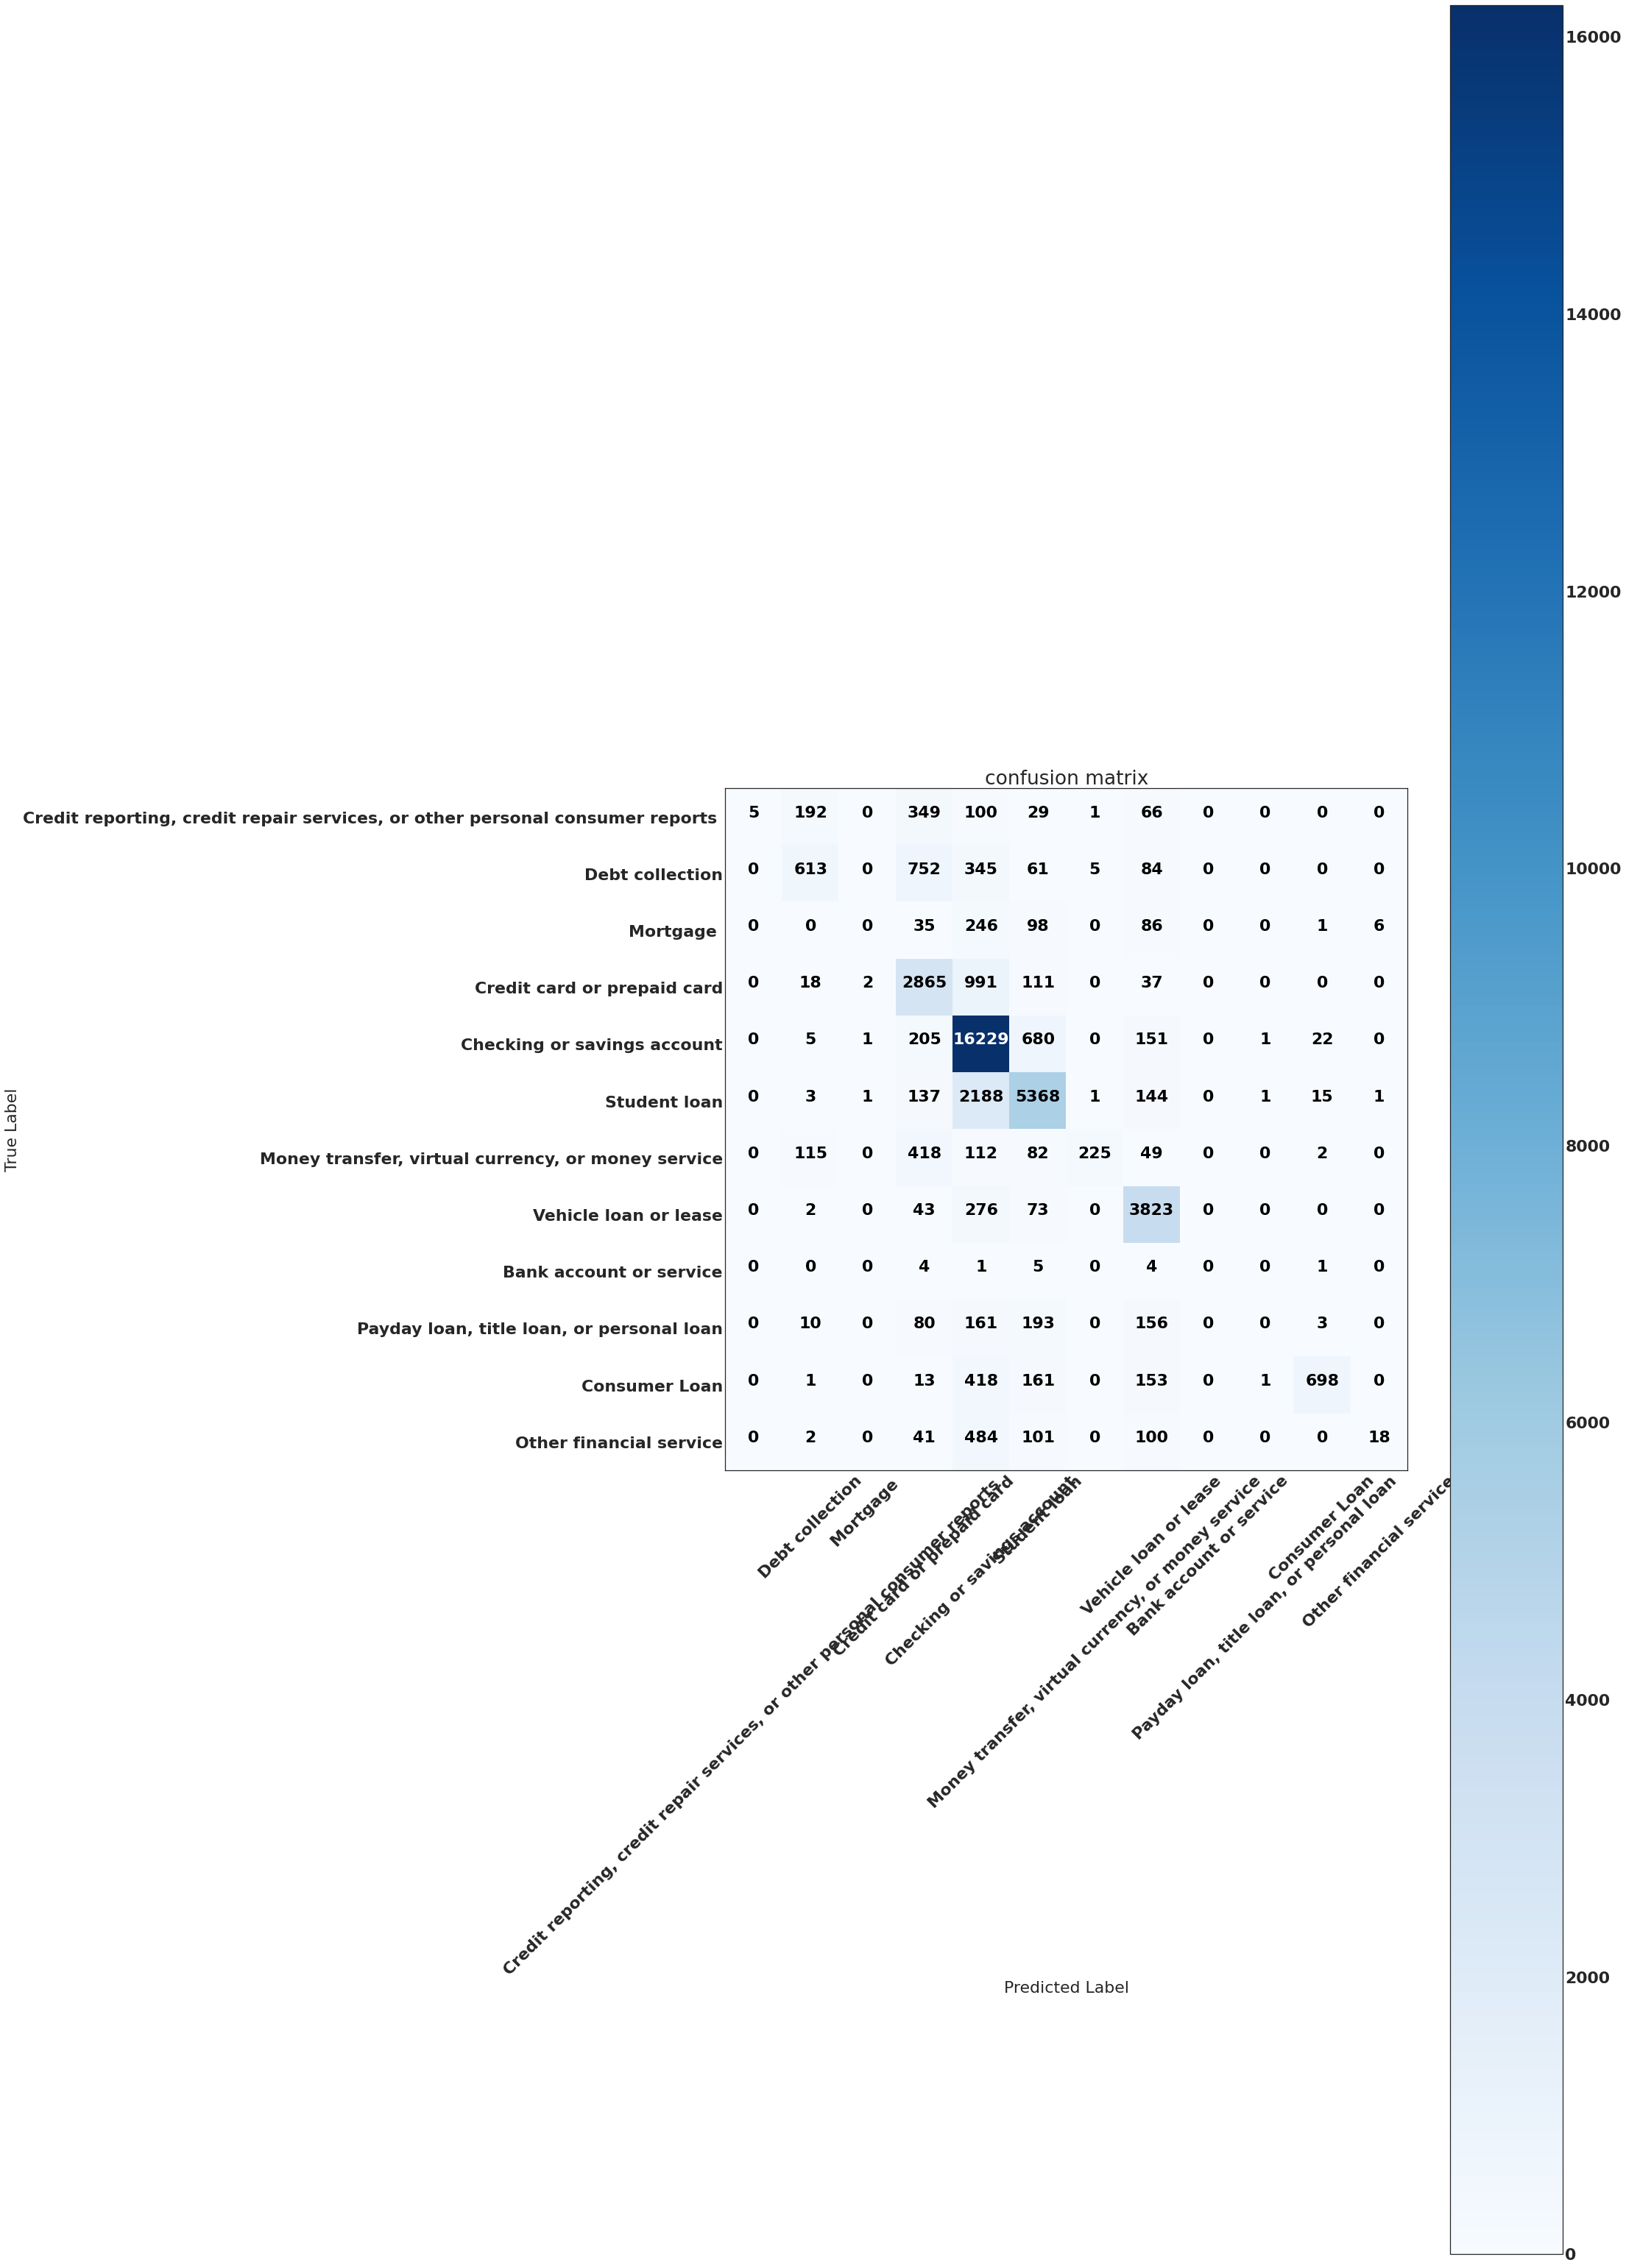

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
cm = metrics.confusion_matrix(y_test_fold, y_predicted)
plt.figure(figsize=(30,45))
plot_confusion_matrix(cm, classes=['Credit reporting, credit repair services, or other personal consumer reports ','Debt collection','Mortgage ','Credit card or prepaid card','Checking or savings account','Student loan','Money transfer, virtual currency, or money service','Vehicle loan or lease','Bank account or service','Payday loan, title loan, or personal loan','Consumer Loan','Other financial service'])

In [ ]:
print('Micro Precision: {:.2f}'.format(precision_score(y_test_fold, y_predicted, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_fold, y_predicted, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_fold, y_predicted, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_fold, y_predicted, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_fold, y_predicted, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_fold, y_predicted, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_fold, y_predicted, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_fold, y_predicted, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_fold, y_predicted, average='weighted')))

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.60
Macro Recall: 0.36
Macro F1-score: 0.38

Weighted Precision: 0.73
Weighted Recall: 0.74
Weighted F1-score: 0.71


- The model is providing good Accuracy with all the metrics.


- Micro Average Precision is the sum of all true positives and divides by the sum of all true positives plus the sum of all false positives. So basically you divide the number of correctly identified predictions by the total number of predictions.

- Macro-precision measures the average precision per class. It’s short for macro-averaged precision.

- Micro-recall measures the recall of the aggregated contributions of all classes. 

- It's short for micro-averaged recall. Micro-recall = 1 means the model's predictions are perfect, all truly positive samples was predicted as the positive class.

### Model Deployement:

In [ ]:
model = pickle.dump(nb,open('complaints.pkl','wb'))

In [ ]:
load_model = pickle.load(open('complaints.pkl', 'rb'))

In [ ]:
load_model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)